In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
#from pandas_datareader import data
from datetime import date
from scipy.optimize import minimize
#import getFamaFrenchFactors as gff
import zipfile
import urllib.request
import copy
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import scipy.linalg as la
import numpy.random as ra
#import scipy.stats import

import matplotlib.pyplot as plt
#from bokeh.io import output_notebook

In [2]:
period=1 #si es 0 sera diaria y 1 si es mensual
tipo_rt=1 #si es 0 sera rendimientos ln y 1 si son redimientos  fama french 

In [7]:
tickers = [
    'AMGN', # AMGEN inc -> biotech
    'A', # Agilent -> biotech
    'TMO', # Thermofisher -> biotech
    'VRTX', # Vertex phrmaceuticals -> biotech
    'BMRN', # Biomarine pharmaceuticals -> biotech
    'PFE', # Pfizer -> biotech
    'MRK', # Merk -> biotech
    'TSM', # Taiwan semi-conductor -> chips
    'QCOM', # Qualcomm -> chips
    'XLNX', # Xilix -> chips
    'NVDA', # NVIDIA -> chips (GPUS)
    'AMD', # AMD -> CPUs (chips)
    'ASML', # ASML chips
    'MU', # Micorn chips (storage)
    'BYND', # Beyond Meat food
    'ADM', # Archer Daniels food,
    'TSN', # Tyson foods
    'EL', # cosmetics
    'TWTR', # twitter -> social media
    'FB', # facebook -> social media
    'GOOGL', # google -> tech/cloud
    'MSFT', # microsoft -> tech/cloud
    'DDOG', # Datadog -> cloud
    'ABNB', # AIRBNB -> travel/tech
    'TEAM', # attlasian -> tech/cloud
    'VMW', # VMWare -> tech/cloud
    'DIS', # Disney -> travel/entretaiment
    'NFLX', # Netflix -> tech/entretainement
    'MNST', # Monster -> vicios Gen Z
]

In [8]:
# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2019-01-01'
end_date = date.today()

In [9]:
data_yahoo=pd.DataFrame(yf.download(tickers,start=start_date,end=end_date))
#data_yahoo=pd.DataFrame(yf.download(tickers,start=start_date,end=end_date, threads=False))
precios=data_yahoo['Adj Close']# se toma el precio de cierre
precios=precios.fillna(method='bfill')#llena los na con el primer valor sig

[*********************100%***********************]  29 of 29 completed


In [ ]:
def get_fama_french(periodo):
    # Web url
    if period==0:
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
    else:
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
    
    # Download the file and save it
    # We will name it fama_french.zip file
    urllib.request.urlretrieve(ff_url,'fama_french.zip')
    zip_file = zipfile.ZipFile('fama_french.zip', 'r')
    
    # Next we extact the file data   
    zip_file.extractall()
    
    # Make sure you close the file after extraction 
    zip_file.close()
    
    # Now open the CSV file    
    ff_factors =pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows = 3, index_col = 0)

    # Format the date index
    ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m%d')
    
    # Format dates to end of month
    #ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()

    return pd.DataFrame(ff_factors)


In [ ]:
def famafrench_nfac():
    betas={}
    scores={}
    datas={}
    ER_Fama=pd.DataFrame()
    x_columns=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'] #factores fama french
    for i in tickers:
        temp=pd.DataFrame()
        temp=copy.deepcopy(data[risk_factors+[i]])#crea una copia independiente de los factores + accion
        temp[i+'-RF']=temp[i]-temp['RF'] #return - rf
        datas[i]=temp #guarda la base de cada accion y sus respectivos factores
        Y=datas[i].iloc[:,-1] #variable independiente accion -rf
        X=(datas[i])[x_columns] #variables dependientes (factores de riesgo)
        reg = LinearRegression( fit_intercept=False).fit(X, Y) #regresion
        score=reg.score(X, Y)#R2 de la regresion
        coefs=reg.coef_ #sensibilades
        betas[i]=coefs
        scores[i]=score
        ER_Fama[i]=np.sum(X*coefs,axis=1)+data['RF'] #expected returns de los fama french

    #ER_Fama_mean=list(ER_Fama.mean())#matriz de expected returns con CAPM N factores
    #cov_matrix=ER_Fama.cov()#matriz de covarianzas
    return(ER_Fama)

In [ ]:
ff_data = get_fama_french(period)
market_cap=data_yahoo['Adj Close'].fillna(0)*data_yahoo['Volume'].fillna(0) #markets caps

if period==0:#diarios
    ln_Rt=(np.log(precios / precios.shift(1)))[1:] #rendimientos logaritmicos
    ln_Rt.index = pd.to_datetime(ln_Rt.index, format= '%Y%m%d')
    #ln_Rtmean=list(ln_Rt.mean()) #medias de los rendimientos logaritmicos
    W0 = [(1/ len(precios.columns)) for i in range(len(precios.columns))] #pesos iniciales 1/n acciones
    #cov_matrix=ln_Rt.cov() #covarianzas de los ln rt
    data=ln_Rt.merge(ff_data,left_index=True, right_index=True) #cruce de datos respecto a la fecha
    risk_factors=list(ff_data.columns) #factores de riesgo fama french
    tickers=list(ln_Rt.columns) #tickers de las acciones
    if tipo_rt==0:
        ERT=list(ln_Rt.mean()) #medias de los rendimientos logaritmicos
        cov_matrix=ln_Rt.cov() #covarianzas de los ln rt
        RTF=ln_Rt
    else:
        RTF=famafrench_nfac()
        ERT=list(RTF.mean())#matriz de expected returns con CAPM N factores
        cov_matrix=RTF.cov()#matriz de covarianzas
        
else:
    precios=precios.resample('1M').last()
    ln_Rt=(np.log(precios / precios.shift(1)))[1:] #rendimientos logaritmicos
    ln_Rt.index = pd.to_datetime(ln_Rt.index, format= '%Y%m%d')
    #ln_Rtmean=list(ln_Rt.mean()) #medias de los rendimientos logaritmicos
    W0 = [(1/ len(precios.columns)) for i in range(len(precios.columns))] #pesos iniciales 1/n acciones
    #cov_matrix=ln_Rt.cov() #covarianzas de los ln rt
    data=ln_Rt.merge(ff_data,left_index=True, right_index=True) #cruce de datos respecto a la fecha
    risk_factors=list(ff_data.columns) #factores de riesgo fama french
    tickers=list(ln_Rt.columns) #tickers de las acciones
    if tipo_rt==0:
        ERT=list(ln_Rt.mean()) #medias de los rendimientos logaritmicos
        cov_matrix=ln_Rt.cov() #covarianzas de los ln rt
        RTF=ln_Rt
    else:
        RTF=famafrench_nfac()
        ERT=list(RTF.mean())#matriz de expected returns con CAPM N factores
        cov_matrix=RTF.cov()#matriz de covarianzas

In [679]:
#optimizacion SRF
rf=data['RF'].mean()
def SR(w,rf,rt):#funcion de sharpe ratio
    R=np.sum(rt*w)
    V=np.sqrt(np.dot(w.T,np.dot(cov_matrix,w)))
    return(R-rf)/V

limites=tuple([(0,1) for i in range(len(precios.columns))])
restriciones=({'type':'eq','fun':lambda x:np.sum(x)-1})
w_optSRF=minimize(lambda x: -1*SR(x,rf,ERT),W0,method='SLSQP',bounds=limites,constraints=restriciones) #maximizar SR
#maximizando SR
woptSRF=w_optSRF.x #pesos optimos
R_SRF=np.sum(ERT*woptSRF) #rendimiento maximo optimizando el SR
V_SRF=np.sqrt(np.dot(woptSRF.T,np.dot(cov_matrix,woptSRF)))#Riesgo minimo optimizando el SR

print(wopt*100) #pesos optimos
print(R_SRF,V_SRF,(R_SRF-rf)/V_SRF) # rendimiento optimo, riesgo y sharpe ratio

[2.75421203e-15 0.00000000e+00 1.45186728e-15 0.00000000e+00
 0.00000000e+00 3.61819318e-15 1.29553913e-15 1.96877696e+01
 0.00000000e+00 2.11949253e-15 1.07600604e-15 9.18859490e+00
 0.00000000e+00 0.00000000e+00 1.19815440e-15 0.00000000e+00
 0.00000000e+00 1.11050847e+01 2.29940314e+01 0.00000000e+00
 2.74200302e+01 2.49896237e-15 2.02569336e-15 0.00000000e+00
 2.31220981e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.60448914e+00]
0.013967075035395493 0.013107630707901363 0.7724485071229693


In [680]:
#optimizacion SR
rf=0
def SR(w,rf,rt):#funcion de sharpe ratio
    R=np.sum(rt*w)
    V=np.sqrt(np.dot(w.T,np.dot(cov_matrix,w)))
    return(R-rf)/V

limites=tuple([(0,1) for i in range(len(precios.columns))])
restriciones=({'type':'eq','fun':lambda x:np.sum(x)-1})
w_optSR=minimize(lambda x: -1*SR(x,rf,ERT),W0,method='SLSQP',bounds=limites,constraints=restriciones) #maximizar SR
#maximizando SR
woptSR=w_optSR.x #pesos optimos
R_SR=np.sum(ERT*woptSR) #rendimiento maximo optimizando el SR
V_SR=np.sqrt(np.dot(woptSR.T,np.dot(cov_matrix,woptSR)))#Riesgo minimo optimizando el SR

print(wopt*100) #pesos optimos
print(R_SR,V_SR,(R_SR-rf)/V_SR) # rendimiento optimo, riesgo y sharpe ratio

[2.75421203e-15 0.00000000e+00 1.45186728e-15 0.00000000e+00
 0.00000000e+00 3.61819318e-15 1.29553913e-15 1.96877696e+01
 0.00000000e+00 2.11949253e-15 1.07600604e-15 9.18859490e+00
 0.00000000e+00 0.00000000e+00 1.19815440e-15 0.00000000e+00
 0.00000000e+00 1.11050847e+01 2.29940314e+01 0.00000000e+00
 2.74200302e+01 2.49896237e-15 2.02569336e-15 0.00000000e+00
 2.31220981e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.60448914e+00]
0.0066386361083780555 0.004386831026635241 1.5133101931828863


In [681]:
#minima varianza
def minvariance(w):
    V=np.sqrt(np.dot(w.T,np.dot(cov_matrix,w)))
    return V

def retorno(w):
    return np.sum(ERT*w)

limites=tuple([(0,1) for i in range(len(precios.columns))])
restriciones=({'type':'eq','fun':lambda x:np.sum(x)-1}) 
v_opt=minimize(minvariance,W0,method='SLSQP',bounds=limites,constraints=restriciones) #minimizar riesgo
minVR=np.sum(ERT*v_opt.x)#rendimiento optimo
minV=np.sqrt(np.dot((v_opt.x).T,np.dot(cov_matrix,v_opt.x)))#minima varianza
print(minVR,minV)

0.006008832571882741 0.004175157629900618


In [682]:
desviaciones=RTF.std()
#maximizar diversificacion
def mindev(w):
    dev=(np.dot(w.T,desviaciones))/np.sqrt(np.dot(w.T,np.dot(cov_matrix,w)))
    return dev

def retorno(w):
    return np.sum(ERT*w)

limites=tuple([(0,1) for i in range(len(precios.columns))])
restriciones=({'type':'eq','fun':lambda x:np.sum(x)-1}) 
dev_v_opt=minimize(lambda x: -1*mindev(x),W0,method='SLSQP',bounds=limites,constraints=restriciones) #maximizar diversificacion
devR=np.sum(ERT*dev_v_opt.x)#rendimiento optimo
devV=np.sqrt(np.dot((dev_v_opt.x).T,np.dot(cov_matrix,dev_v_opt.x)))#varianza
print(devR,devV)

0.0059540314311603 0.0042158246105244435


In [683]:
#frontera eficiente
returns=np.linspace(minVR,np.maximum(np.maximum(devR,R_SRF),0),100)#R_SRF
riesgo=[]
datos=[]

for ri in returns:
    restriciones=({'type':'eq','fun':lambda x:np.sum(x)-1},
             {'type':'eq','fun':lambda x:retorno(x)-ri}) 
    v_opt=minimize(minvariance,W0,method='SLSQP',bounds=limites,constraints=restriciones) #minimizar Var
    riesgo.append(v_opt['fun'])
    datos.append(riesgo)
#(pd.DataFrame(returns,riesgo)).to_excel('sim.xlsx', index=True) #se convierte en excel el insumo ara

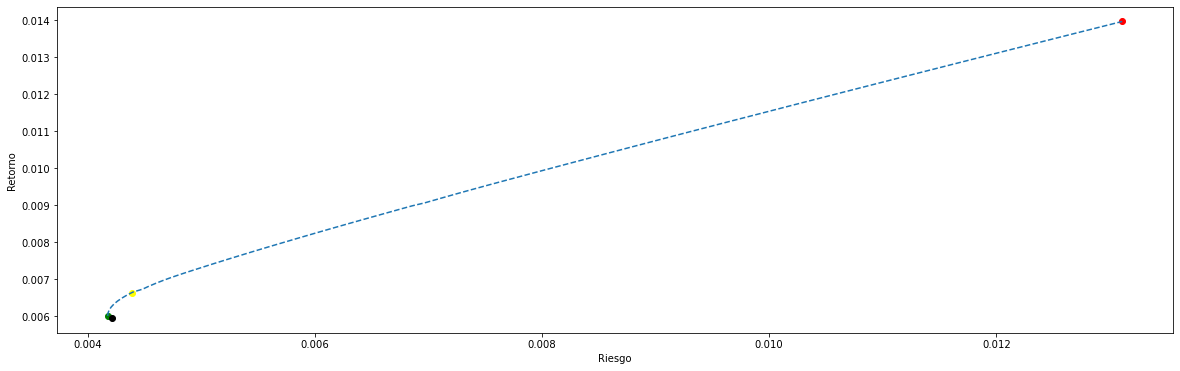

In [684]:
plt.figure(figsize=(20,6))
plt.xlabel('Riesgo')
plt.ylabel('Retorno')
plt.scatter(V_SR,R_SR,c='yellow')#SR sin rf
plt.scatter(V_SRF,R_SRF,c='red')#SR con rf
plt.scatter(minV,minVR,c='green')#min riesgo
plt.scatter(devV,devR,c='black')#max diversificacion
plt.plot(riesgo,returns,'--')
plt.show()
           

In [759]:
# T_S=[0,0.5,1] # desbloquear esta parte e insertar tiempos especificos para evaluar los subyacentes
nSims =100# numero de simulaciones

rng = ra.RandomState(3426) #se declara una semilla para garantizar que los resultados son replicables.
# rng=None #se utlitza para no utilizar semilla

#se define función de antiteticas
def Antiteticas(nSims,S0,rng):
    subs=len(S0)
    nSimReal = nSims // 2  # nSims es el 2N de la explicacion. //:division entera
    # Valores con las normales originales
    normales= norm.rvs(size=(subs, nSimReal), random_state=rng)
    # Valores con las normales simetricas
    normalesSim = -normales
    T_normales=np.hstack((normales,normalesSim))
    #se extrae matriz de las covarianzas de las normales generadas
    mat_cov=np.cov(T_normales)
    #se extrae la inversa de la cholesky de la matriz de covarainzas
    ch_T = la.inv(la.cholesky(mat_cov)).T
    #Se multiplica cholesly por normales
    T_normales = np.dot(ch_T, T_normales)
    return T_normales


In [760]:
Z= Antiteticas(nSims,tickers,rng) #normales 0,1 con matriz de correlacion limpia
corr_RTF=ln_Rt.corr()
chol_corr_RTF= la.cholesky(corr_RTF).T
Z_corr = np.dot(chol_corr_RTF, Z).T #normales 0,1 con matriz de correlacion objetivo lnRT
#pd.DataFrame(Z_corr).corr()
Z_corr.shape

(100, 29)

In [761]:
P0=np.array(precios.iloc[-1])
#P0.shape=[1,len(P0)]
r=data['RF'].mean()
sigmas=np.array(ln_Rt.std())
#sigmas.shape=[1,len(sigmas)]
ST=P0*np.exp(((r-.5*sigmas**2)) + (sigmas*Z_corr)) #posibles precios
Rt_cont=(((r-.5*sigmas**2)) + (sigmas*Z_corr))-1  #rendimientos
Capital=1000000 #1,000,000
Pesos=W0
Titulos=np.array(W0)*Capital/P0
Escenarios=Rt_cont*Titulos*P0
PL=np.sum(Escenarios[:],axis=1)
#(pd.DataFrame(Escenarios)).to_excel('sim.xlsx', index=True) #se convierte en excel el insumo ara

In [767]:
alpha=0
Perdida_mc= np.percentile(PL,alpha)
print("tu Var MC es de:" ,"{:,.2f}".format(Perdida_mc))
print()

tu Var MC es de: -1,149,965.41



In [751]:
(pd.DataFrame(PL)).sort_values(by=0, ascending=True)

,0
97,-1.149965e+06
74,-1.101952e+06
64,-1.091625e+06
49,-1.082112e+06
4,-1.078288e+06
...,...
54,-9.235830e+05
99,-9.197592e+05
14,-9.102459e+05
24,-8.999188e+05


In [690]:
#colors =['darkblue','orange','red']
#data.plot_bokeh.line(figsize=(900,450),
                    #colormap=colors,
                    #rangetool=True,
                    #xlabel='fecha',
                    #ylabel='cotizaciones',
                    #title='prueba')